## Accessing Esri 10-Meter Land Cover data on Azure

This dataset includes global estimates of 10-class land use/land cover (LULC) for 2020, derived from ESA Sentinel-2 imagery at 10m resolution. This dataset was generated by [Impact Observatory](https://impactobservatory.com), who used billions of human-labeled pixels (curated by the National Geographic Society) to train a deep learning model for land classification. The global map was produced by applying this model to the Sentinel-2 2020 scene collection on the Planetary Computer.

This notebook demonstrates access to LULC data on Azure, using mgrs

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-sentinel-2](http://aka.ms/ai4edata-io-lulc).

### Environment setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.windows import Window
from pyproj import Transformer        

import mgrs
from azure.storage.blob import ContainerClient

### Constants

In [11]:
# Around Auckland, NZ
lat = -36.852095
lon = 174.76318

# For the 2020 map, the start date and end date are...
start_date = '20200101'
end_date   = '20210101'
tile_suffix = '_' + start_date + '-' + end_date + '.tif'

# Target image size and "zoom factor"
target_size = [720,405]
oversample = 12.5

image_folder = 'https://ai4edataeuwest.blob.core.windows.net/io-lulc/io-lulc-model-001-v01-composite-v03-supercell-v02-clip-v01/'

### Find MGRS code for this location

In [12]:
mgrs_location = mgrs.MGRS().toMGRS(lat, lon)
print(mgrs_location)

# We only use the three-character prefix
tile_prefix = mgrs_location[0:3]
print(tile_prefix)

60HUE0057719199
60H


### Create the target tile URL

In [13]:
target_url = image_folder + tile_prefix + tile_suffix
print(target_url)

https://ai4edataeuwest.blob.core.windows.net/io-lulc/io-lulc-model-001-v01-composite-v03-supercell-v02-clip-v01/60H_20200101-20210101.tif


### Render the COG thumbnail for this tile

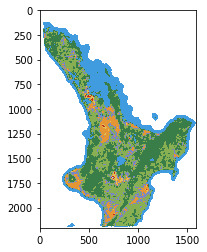

In [22]:
from matplotlib.colors import ListedColormap

with rasterio.open(target_url) as src:
    
    # List of overviews from biggest to smallest
    oviews = src.overviews(1)

    # Retrieve the smallest thumbnail
    oview = oviews[-1]
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
    # Get the colormap too, and convert to a matplotlib color map
    colormap_def = src.colormap(1)
    colormap = [np.array(colormap_def[i]) / 255 for i in range(n_classes)]
    cmap = ListedColormap(colormap)

plt.imshow(thumbnail,cmap=cmap);

### Crop to our target size around our target point

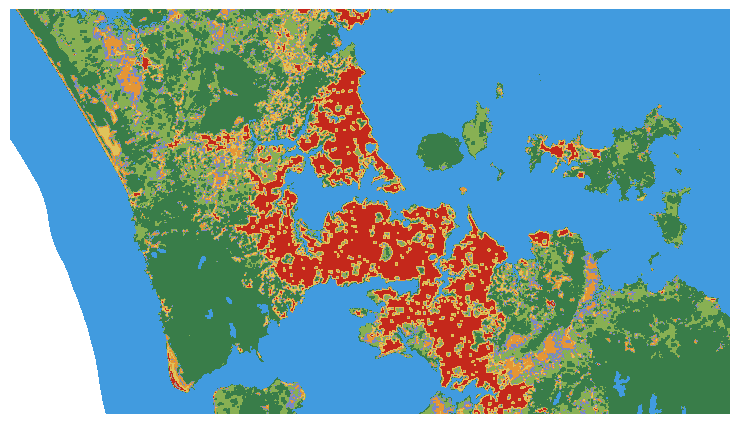

In [25]:
with rasterio.open(target_url,'r') as src:

    xsize = (target_size[0] * oversample)
    ysize = (target_size[1] * oversample)

    transformer = Transformer.from_crs('EPSG:4326', src.crs, always_xy=True)
    xx, yy = transformer.transform(lon, lat)
    py, px = src.index(xx,yy)    
    xoff = px - xsize // 2 
    yoff = py - ysize // 2 
    window = Window(xoff,yoff,xsize,ysize)

    image_data = src.read(1, window=window)
    
    # Get the colormap too, and convert to a matplotlib color map
    colormap_def = src.colormap(1)
    colormap = [np.array(colormap_def[i]) / 255 for i in range(n_classes)]
    cmap = ListedColormap(colormap)
    
# ...with rasterio.open()
    
# ...for each file

w = target_size[0]; h = target_size[1]
dpi = 100; fig = plt.figure(frameon=False,figsize=(w/dpi,h/dpi),dpi=dpi)
ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)

plt.imshow(image_data,cmap=cmap);